# Make 2d-trigger efficiency plots
- loads an output pkl file processed by the `trigger_efficiencies_processor.py` June 25th iteration which does not apply the dxy, dz requirements on the Muons but saves them as booleans `muon_dxy`, `muon_dz`
- checks the effect of the dxy, dz requirements on the trigger efficiency plots

In [260]:
import glob
import json
import os
import pickle
import pickle as pkl

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import yaml
from hist.intervals import clopper_pearson_interval
from scipy.special import softmax
from sklearn.metrics import auc, roc_curve

pd.options.mode.chained_assignment = None

plt.rcParams.update({"font.size": 20})
plt.style.use(hep.style.CMS)

In [261]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [272]:
ch = "mu"

with open("/Users/fmokhtar/Desktop/AN_2024/trigger/with_and_without_dxydz/0-100.pkl", "rb") as f:
    file = pkl.load(f)
    
    trg_dict = file["2017"]["GluGluHToWW_Pt-200ToInf_M-125"]["skimmed_events"][ch]["triggers"]
    var_dict = file["2017"]["GluGluHToWW_Pt-200ToInf_M-125"]["skimmed_events"][ch]["vars"]
    weight_dict = file["2017"]["GluGluHToWW_Pt-200ToInf_M-125"]["skimmed_events"][ch]["weights"]

var_dict["fj_genH_pt"] = var_dict["fj_genH_pt"].reshape(-1)

In [274]:
nev = len(var_dict["fj_genH_pt"])
print("Events before trigger: ", nev)

########## build the OR of all triggers
msk_trg = np.zeros(len(trg_dict["HLT_IsoMu27"]), dtype="bool")

for trig in trg_dict:
    msk_trg = msk_trg | trg_dict[trig]

print("Events after trigger: ", msk_trg.sum())

print("----------------------")
print("Trigger eff: ", msk_trg.sum()/nev)

########## get the dxy, dz mask
msk_dxyz = (var_dict["muon_dxy"] & var_dict["muon_dz"])    
print("Trigger eff after dxyz req: ", (msk_trg & msk_dxyz).sum()/nev)

Events before trigger:  7735
Events after trigger:  7176
----------------------
Trigger eff:  0.9277310924369748
Trigger eff after dxyz req:  0.9261797026502909


# Muon kinematics

In [275]:
outdir = f"/Users/fmokhtar/Desktop/AN_2024/trigger/"

if not os.path.exists(outdir):
    os.makedirs(outdir)

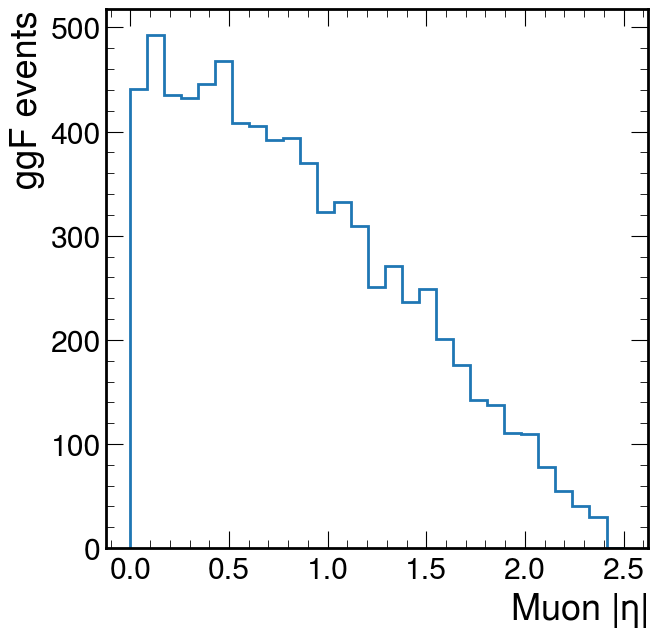

In [276]:
fig, ax = plt.subplots(figsize=(7,7))

ax.hist(
    abs(var_dict["lep_eta"]),
    bins=np.linspace(0,2.5,30),
    histtype="step",
    lw=2,
)

ax.set_xlabel(r"Muon $|\eta|$")
ax.set_ylabel("ggF events");

plt.savefig(f"{outdir}/{ch}_eta.pdf")

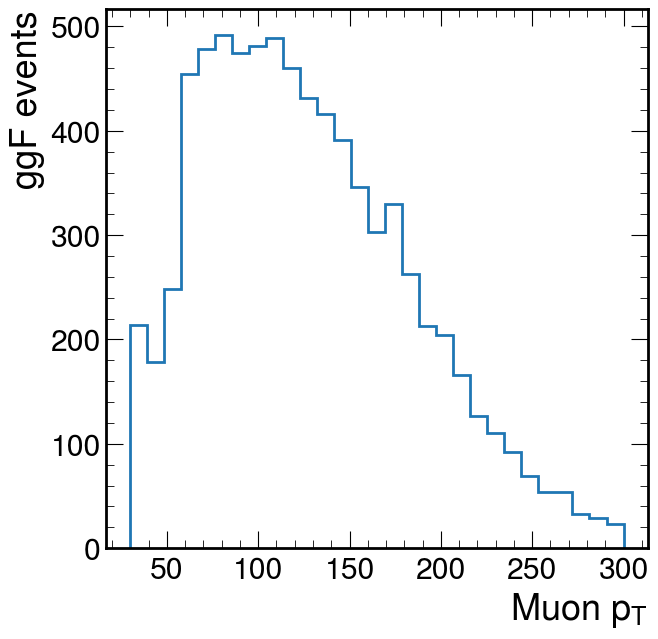

In [277]:
fig, ax = plt.subplots(figsize=(7,7))

ax.hist(
    var_dict["lep_pt"],
    bins=np.linspace(30,300,30),
    histtype="step",
    lw=2,
)

ax.set_xlabel(r"Muon $p_T$")
ax.set_ylabel("ggF events");

plt.savefig(f"{outdir}/{ch}_pt.pdf")

# 2d efficiency plots

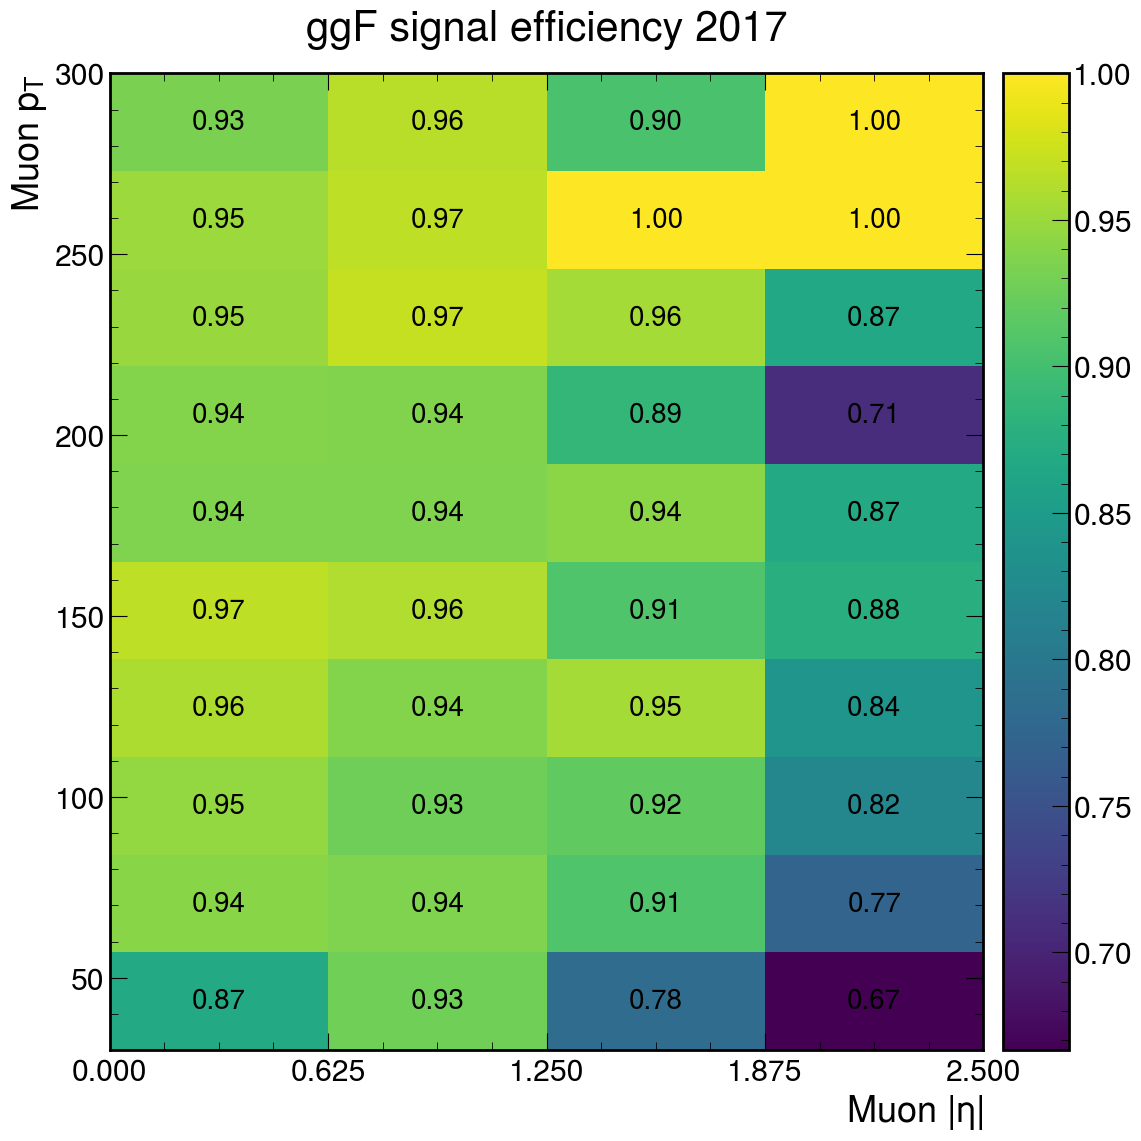

In [278]:
efficiencyinfo = (
    hist2.Hist.new.Reg(4, 0, 2.5, name="eta")
    .Reg(10, 30, 300, name="pt")
    .Bool(name="pass_trg")
    .Bool(name="pass_dxyz")    
    .Double()
    .fill(
        eta=abs(var_dict["lep_eta"]),
        pt=var_dict["lep_pt"],        
        pass_trg=msk_trg,
        pass_dxyz=msk_dxyz,
    )
)
h = efficiencyinfo[{"pass_trg": True, "pass_dxyz": sum}] / efficiencyinfo[{"pass_trg": sum, "pass_dxyz": sum}]

# make 2dplot of the eff
fig, ax = plt.subplots(figsize=(12, 12))

hep.hist2dplot(h, ax=ax, flow=None)

for i in range(h.axes[0].size):
    for j in range(h.axes[1].size):
        bin_value = h.values()[i, j]
        bin_center_x = h.axes[0].centers[i]
        bin_center_y = h.axes[1].centers[j]
        ax.text(bin_center_x, bin_center_y, f'{bin_value:.2f}', 
                color='black', ha='center', va='center', fontsize=20)

ax.set_title(f'ggF signal efficiency 2017', pad=24, fontsize=30)
ax.set_xlabel(r"Muon $|\eta|$")
ax.set_ylabel(r"Muon $p_T$")

plt.tight_layout()

plt.savefig(f"{outdir}/mu_trgeff_2d_without_dxyz.pdf")

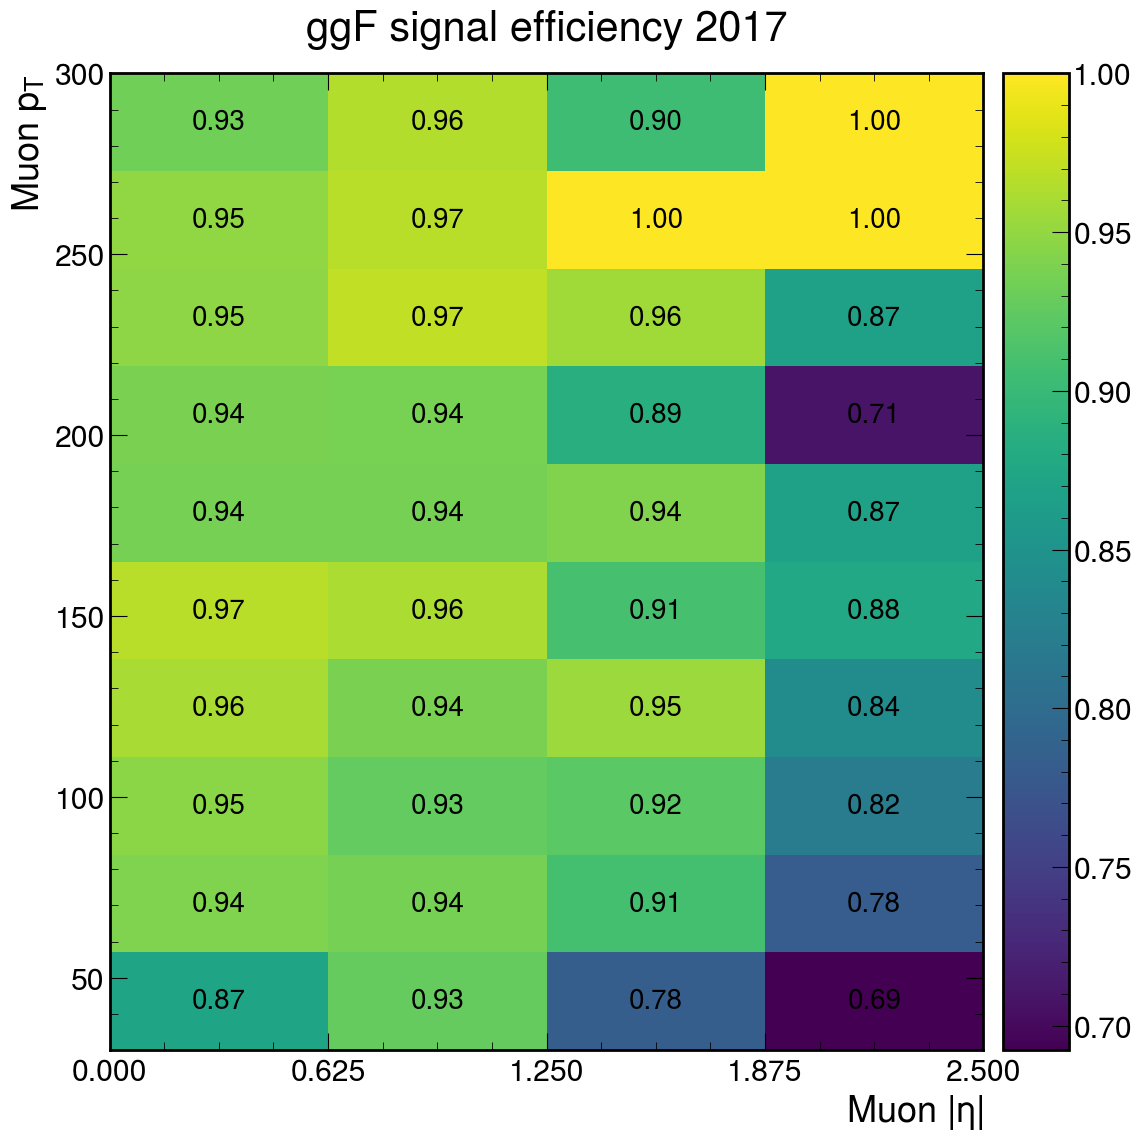

In [279]:
efficiencyinfo = (
    hist2.Hist.new.Reg(4, 0, 2.5, name="eta")
    .Reg(10, 30, 300, name="pt")
    .Bool(name="pass_trg")
    .Bool(name="pass_dxyz")    
    .Double()
    .fill(
        eta=abs(var_dict["lep_eta"]),
        pt=var_dict["lep_pt"],        
        pass_trg=msk_trg,
        pass_dxyz=msk_dxyz,
    )
)
h = efficiencyinfo[{"pass_trg": True, "pass_dxyz": True}] / efficiencyinfo[{"pass_trg": sum, "pass_dxyz": True}]

# make 2dplot of the eff
fig, ax = plt.subplots(figsize=(12, 12))

hep.hist2dplot(h, ax=ax, flow=None)

for i in range(h.axes[0].size):
    for j in range(h.axes[1].size):
        bin_value = h.values()[i, j]
        bin_center_x = h.axes[0].centers[i]
        bin_center_y = h.axes[1].centers[j]
        ax.text(bin_center_x, bin_center_y, f'{bin_value:.2f}', 
                color='black', ha='center', va='center', fontsize=20)

ax.set_title(f'ggF signal efficiency 2017', pad=24, fontsize=30)
ax.set_xlabel(r"Muon $|\eta|$")
ax.set_ylabel(r"Muon $p_T$")

plt.tight_layout()

plt.savefig(f"{outdir}/mu_trgeff_2d_with_dxyz.pdf")